In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import *

In [0]:
df = spark.read.json("/FileStore/export/steam_clean")


# Analyse au niveau « macro »

## 1. Quel éditeur a publié le plus de jeux sur Steam ?

In [0]:
df.select('publisher').show(5, truncate=False)

+------------------------+
|publisher               |
+------------------------+
|Valve                   |
|PsychoFlux Entertainment|
|Team17, NEXT Studios    |
|Vertigo Gaming Inc.     |
|DoubleC Games           |
+------------------------+
only showing top 5 rows



In [0]:
df_publisher = df.groupBy('publisher')\
    .count()\
    .orderBy("count", ascending=False)\
    .withColumnRenamed('count', 'total_games')\

df_publisher.show(5, truncate=False)


+--------------+-----------+
|publisher     |total_games|
+--------------+-----------+
|Big Fish Games|422        |
|8floor        |202        |
|SEGA          |165        |
|Strategy First|151        |
|Square Enix   |141        |
+--------------+-----------+
only showing top 5 rows



In [0]:
first_value = df_publisher.select('publisher').first()[0]
print(f"L'éditeur qui a publié le plus de jeux sur Steam est {first_value}")

L'éditeur qui a publié le plus de jeux sur Steam est Big Fish Games


## 2. Quels sont les jeux les mieux notés ?

In [0]:
# Colonne à utiliser
# positive: long (nullable = true), negative: long (nullable = true),name: string (nullable = true)

df.select('name','positive', 'negative').show(5)

+--------------------+--------+--------+
|                name|positive|negative|
+--------------------+--------+--------+
|      Counter-Strike|  201215|    5199|
|           ASCENXION|      27|       5|
|         Crown Trick|    4032|     646|
|Cook, Serve, Deli...|    1575|     115|
|            细胞战争|       0|       1|
+--------------------+--------+--------+
only showing top 5 rows



In [0]:
total_rate = df.withColumn('total_rate', F.col('positive') - F.col('negative')) 
total_rate.select('name','positive', 'negative','total_rate').show(5, truncate=False)

+---------------------------+--------+--------+----------+
|name                       |positive|negative|total_rate|
+---------------------------+--------+--------+----------+
|Counter-Strike             |201215  |5199    |196016    |
|ASCENXION                  |27      |5       |22        |
|Crown Trick                |4032    |646     |3386      |
|Cook, Serve, Delicious! 3?!|1575    |115     |1460      |
|细胞战争                   |0       |1       |-1        |
+---------------------------+--------+--------+----------+
only showing top 5 rows



In [0]:
rate_games = total_rate.select('name', 'total_rate').orderBy('total_rate', ascending=False)
rate_games.show(10, truncate=False)

+--------------------------------+----------+
|name                            |total_rate|
+--------------------------------+----------+
|Counter-Strike: Global Offensive|5156252   |
|Dota 2                          |1216979   |
|Grand Theft Auto V              |1015886   |
|Terraria                        |992331    |
|Garry's Mod                     |831242    |
|Tom Clancy's Rainbow Six Siege  |799663    |
|Team Fortress 2                 |788984    |
|Left 4 Dead 2                   |627008    |
|Rust                            |620359    |
|The Witcher 3: Wild Hunt        |607382    |
+--------------------------------+----------+
only showing top 10 rows



In [0]:
best_games = rate_games.select('name').limit(10)
best_games.show(10, truncate=False)

+--------------------------------+
|name                            |
+--------------------------------+
|Counter-Strike: Global Offensive|
|Dota 2                          |
|Grand Theft Auto V              |
|Terraria                        |
|Garry's Mod                     |
|Tom Clancy's Rainbow Six Siege  |
|Team Fortress 2                 |
|Left 4 Dead 2                   |
|Rust                            |
|The Witcher 3: Wild Hunt        |
+--------------------------------+



##  3. Y a-t-il eu plus de sorties de jeux pendant certaines années ?

In [0]:
#  release_date_clean : date
df.select('release_date_clean').show(5)

+--------------------+
|  release_date_clean|
+--------------------+
|2000-11-01T00:00:...|
|2021-05-14T00:00:...|
|2020-10-16T00:00:...|
|2020-10-14T00:00:...|
|2019-03-30T00:00:...|
+--------------------+
only showing top 5 rows



In [0]:
df = df.withColumn('year', year(col('release_date_clean')))
df.select('year').show(5)

+----+
|year|
+----+
|2000|
|2021|
|2020|
|2020|
|2019|
+----+
only showing top 5 rows



In [0]:
df_year = df.groupBy('year')\
    .count()\
    .withColumnRenamed('count', 'games_count')\
    .orderBy('games_count', ascending=False)


df_year.show(5)


+----+-----------+
|year|games_count|
+----+-----------+
|2021|       8805|
|2020|       8287|
|2018|       7663|
|2022|       7451|
|2019|       6949|
+----+-----------+
only showing top 5 rows



### Les années avec el plus de sortie sd ejeux sont 2020 et 2021, cela correspond à la période du COVID. En 2022, on observe en baisse du nombre de jeux. 

## 4. Y a-t-il beaucoup de jeux avec réduction ? §§§§§§§ FAUX

In [0]:
df.select('discount').show(10)

+--------+
|discount|
+--------+
|       0|
|       0|
|      70|
|       0|
|       0|
|      60|
|       0|
|       0|
|       0|
|       0|
+--------+
only showing top 10 rows



In [0]:

df.groupBy(
    (col("discount") > 0).alias("Avec reduction")
).count().show()


+--------------+-----+
|Avec reduction|count|
+--------------+-----+
|          true| 2518|
|         false|53173|
+--------------+-----+



### La proportion de réduction pour les jeux est trés faible.

## 5. Quelles sont les langues les plus représentées ?

In [0]:
df.select('languages').show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|languages                                                                                                                                                                                                                                                                                                                                 |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|

In [0]:
# Il faut 'exploded' la colonne car les langages sont stockées en chaine de caractére séparé par une virgule
df_language = df \
    .withColumn("language", explode(split(col("languages"), ", "))) \
    .groupBy("language") \
    .count() \
    .orderBy(col("count").desc())

df_language.show(10)


+-------------------+-----+
|           language|count|
+-------------------+-----+
|            English|55116|
|             German|14019|
|             French|13426|
|            Russian|12922|
| Simplified Chinese|12782|
|    Spanish - Spain|12233|
|           Japanese|10368|
|            Italian| 9304|
|Portuguese - Brazil| 6750|
|             Korean| 6599|
+-------------------+-----+
only showing top 10 rows



### On observe que la langue anglaise est largement repésentée avec plus de 55.000 jeux.

## 6. Y a-t-il beaucoup de jeux interdits aux moins de 16/18 ans ?

In [0]:
df.select('required_age', 'name').show(5)


+------------+--------------------+
|required_age|                name|
+------------+--------------------+
|           0|      Counter-Strike|
|           0|           ASCENXION|
|           0|         Crown Trick|
|           0|Cook, Serve, Deli...|
|           0|            细胞战争|
+------------+--------------------+
only showing top 5 rows



In [0]:
df.groupBy('required_age').count().show(10)


+------------+-----+
|required_age|count|
+------------+-----+
|           7|    2|
|          15|  264|
|           3|    3|
|          16|   38|
|           0|55030|
|           5|    1|
|          18|  223|
|          17|   38|
|           6|    4|
|         180|    4|
+------------+-----+
only showing top 10 rows



In [0]:

df.groupBy('required_age') \
  .agg(F.count('name').alias('count_games')) \
  .orderBy('count_games', ascending=False) \
  .show(10)


+------------+-----------+
|required_age|count_games|
+------------+-----------+
|           0|      55030|
|          15|        264|
|          18|        223|
|          16|         38|
|          17|         38|
|          12|         32|
|          13|         26|
|          14|         10|
|          10|          7|
|           6|          4|
+------------+-----------+
only showing top 10 rows



### Les jeux interdits au moins de 16/18 ans représentent une trés petite proportion. 

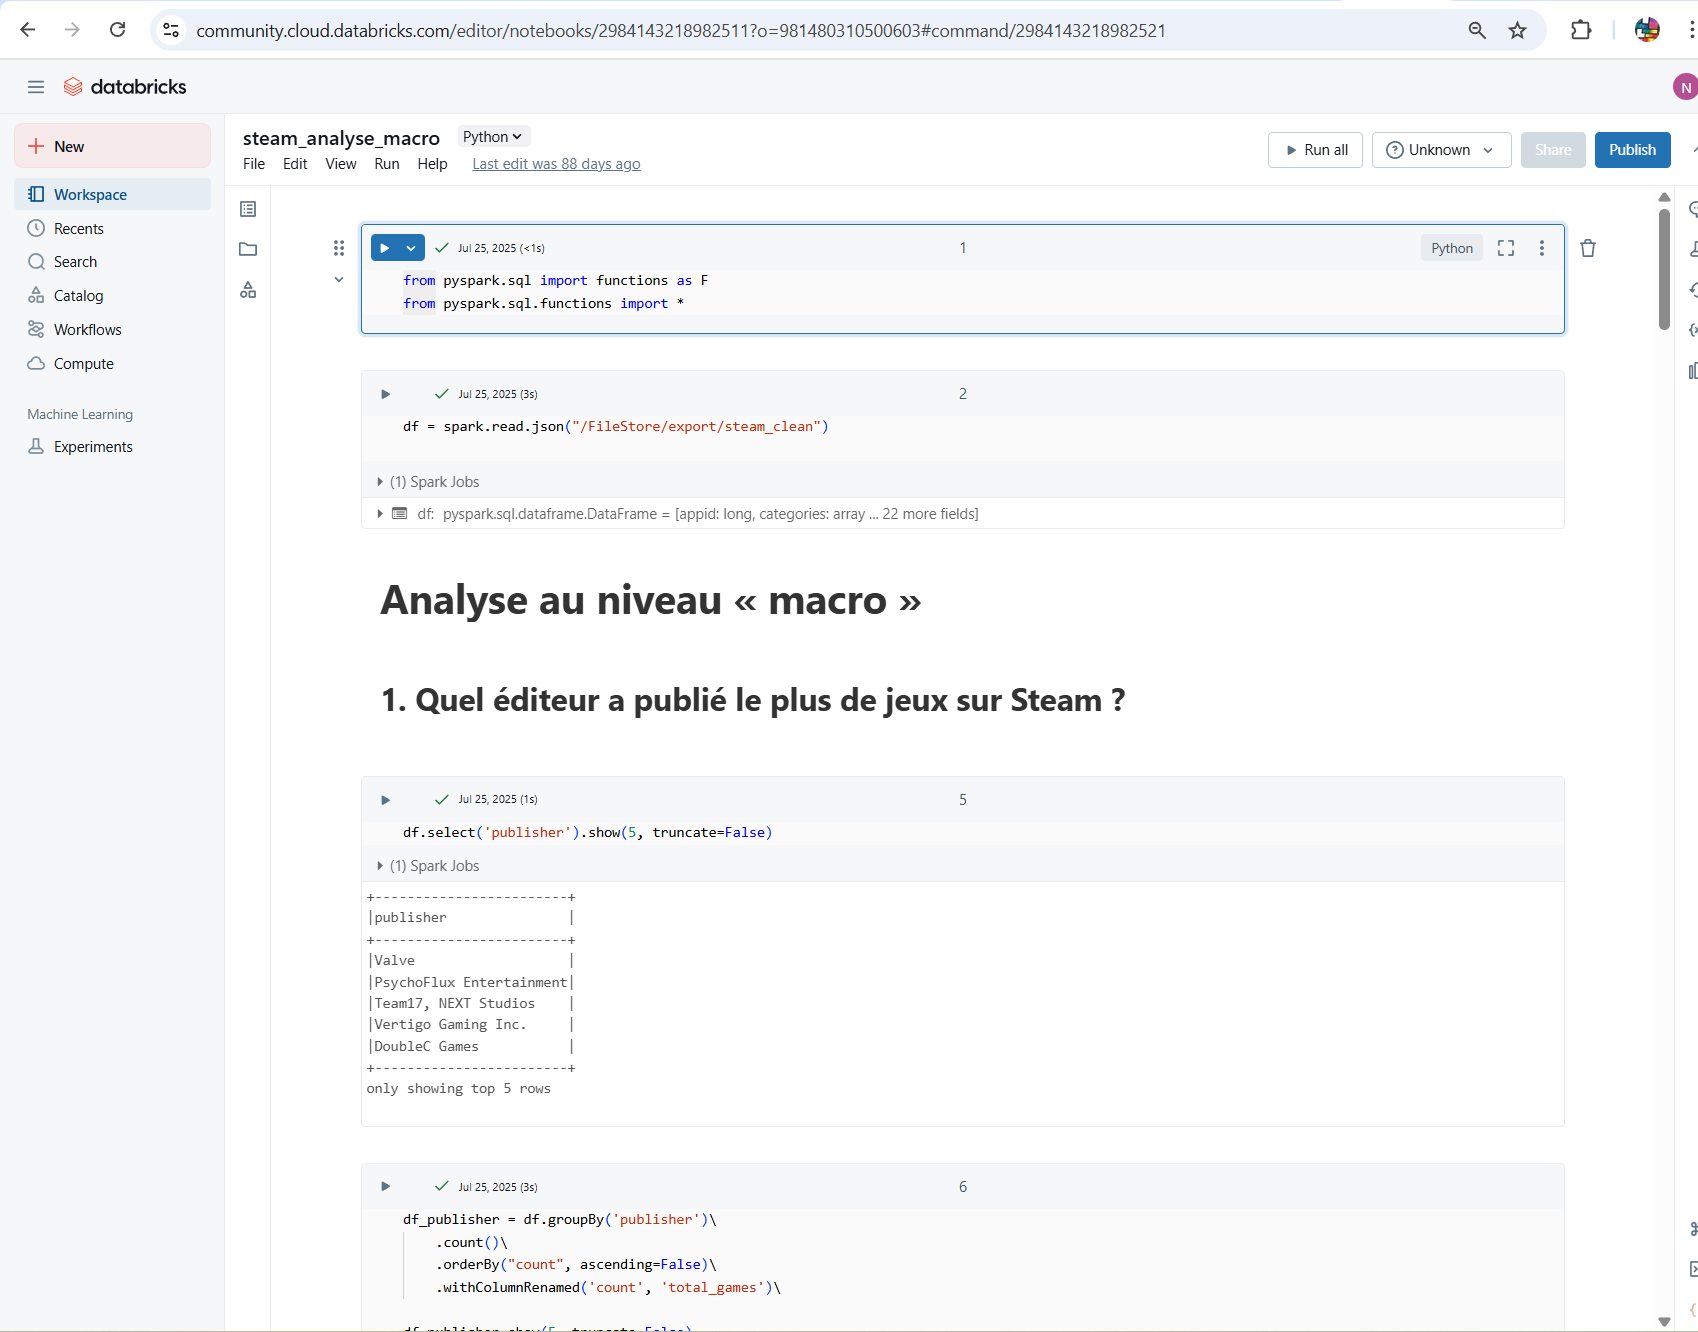
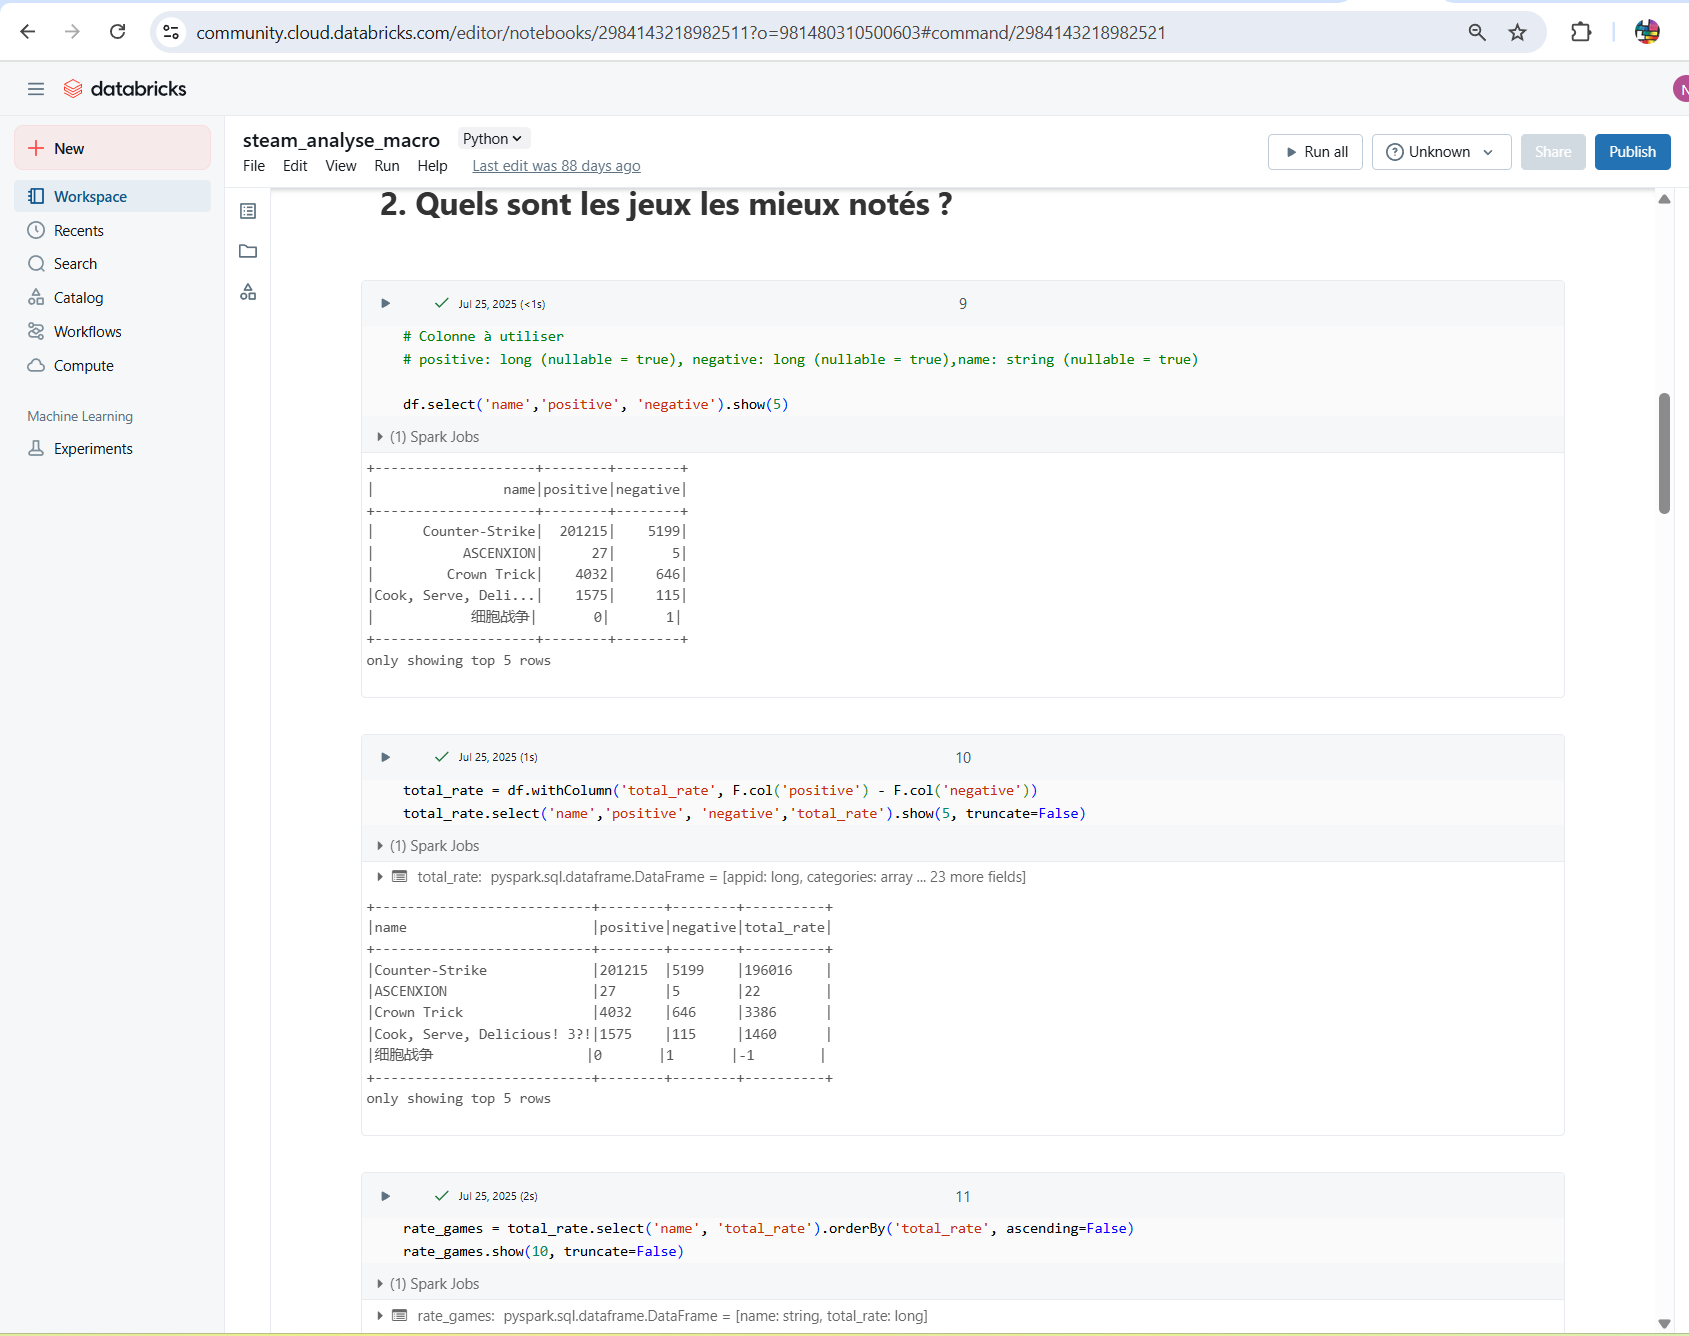